# **Курсовая работа по дисциплине "Автоматика и регулирование ЖРД"**

## Решение системы дифференциальных уравнений

### Система уравнений

$$
\begin{cases}
\begin{align}
\frac{{d}}{{dt}}{p}_{4} &=\frac{\left(m_{1}+{m}_{2}-{m}_{3}-{m}_{\text{д}}\right)}{\frac{{V}_{\text{ж}0^{+}}{V}_{\text{д}}}{{c}^{2}}} \\

\frac{{d}}{{dt}}{V}_{д} &=\frac{m_{д}}{\rho_{ж}} \\

\frac{d}{dt}m_{д} &=\frac{\left[p_{4}-\frac{m_{газ}}{V_{г0}-V_{д}} \cdot R \cdot \left[T_{газ0} \cdot \left(\frac{p_{4}}{p_{4,0}}\right)^{\frac{k-1}{k}}\right]-\xi_{д} \cdot m_{д} \cdot \left|m_{д}\right|\right]}{j_{д}} \\

\frac{{d}}{{dt}}m_1 &=\frac{\left({p}_1-{p}_4-{\xi}_1\cdot{m}_1^2\right)}{{j}_1} \\

{\frac{d}{dt}}m_{2} &={\frac{\left(p_{2}-p_{4}-\xi_{2}\cdot m_{2}^{2}\right)}{j_{2}}} \\

\frac{d}{dt}m_{3} &=\frac{\left({p}_{4}-{p}_{3}-{\xi}_{3}\cdot{m}_{3}^{2}\right)}{{j}_{3}}
\end{align}
\end{cases}
$$

### Функция возмущения

$$
\mathrm{p2(t)}:=\left|
    \begin{matrix}
    A\sin\left(z(t)-\frac{\pi}{2}\right)+A+x_0 \quad &\text{if}\quad &0\leq t \leq T, \\
    x_0 \quad &\text{if}\quad &t\ >\ T 
    \end{matrix}
\right.
$$
где
$$
z(t) = 2 \cdot t \cdot \frac{\pi}{T}
$$

### Исходные данные

In [41]:
from icecream import ic

p1 = 400e3
p2_0 = 300e3
p3 = 100e3

k = 1.4
R = 297
p0_gas = 1.2506

c = 1200

p4_0 = 289442.719
Vд_0 = 0

mд_0 = 0
m1_0 = 10.515
m2_0 = 3.249
m3_0 = 13.764

Vж0 = 0.004
ρж = 820

Tгаз0 = 293
ρг = p4_0 / (R * Tгаз0)
Vг0 = 0.001
mгаз = ρг * Vг0

j1 = 400
j2 = 400
j3 = 400
jд = 20

ξ1 = 1000
ξ3 = 1000
ξ2 = 1000
ξд = 1000

#### Решение методом  `LSODA`

##### Код решения

In [46]:
from scipy.integrate import odeint
import numpy as np
from numpy import pi, sin
import pandas as pd


def system(y, t):
    """ Система дифференциальных уравнений """
    p4, Vд, mд, m1, m2, m3 = y
    
    d_p4 = (m1 + m2 - m3 - mд) / ((Vж0 + Vд) / c**2)
    d_Vд = mд / ρж
    d_mд = (p4 - (mгаз / (Vг0 - Vд)) * R * 
            (Tгаз0 * ((p4 / p4_0)**((k-1)/k))) - 
                ξд * mд * abs(mд)) / jд
    d_m1 = (p1 - p4 - ξ1 * m1 * abs(m1)) / j1
    d_m2 = (p2(t) - p4 - ξ2 * m2 * abs(m2)) / j2
    d_m3 = (p4 - p3 - ξ3 * m3 * abs(m3)) / j3
    
    return [d_p4, d_Vд, d_mд, d_m1, d_m2, d_m3]


def p2(t):
    """ Функция возмущения """
    if t <= T:
        z = 2 * t * pi/T
        insin = z - pi/2
        p2 = p2_0 + A*sin(insin) + A
    else:
        p2 = p2_0
    return p2


A = 1000
T = 0.1

t_end = .8
h = 1e-6

y0 = [p4_0, Vд_0, mд_0, m1_0, m2_0, m3_0]
t = np.arange(0, t_end, h)

# Решение
sol = odeint(system, y0, t)

# Вывод таблицы значений
# ic(pd.DataFrame(data=sol, index=t))

##### Графики

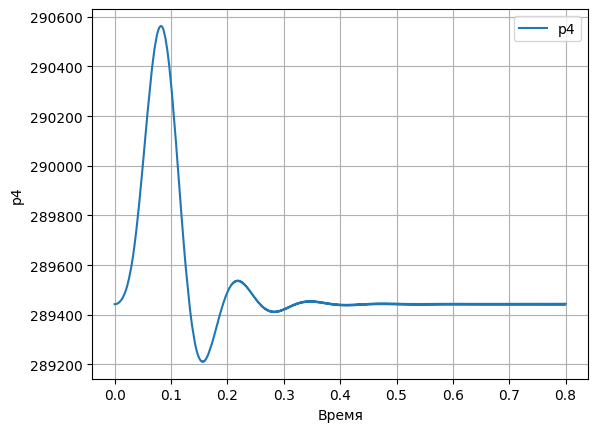

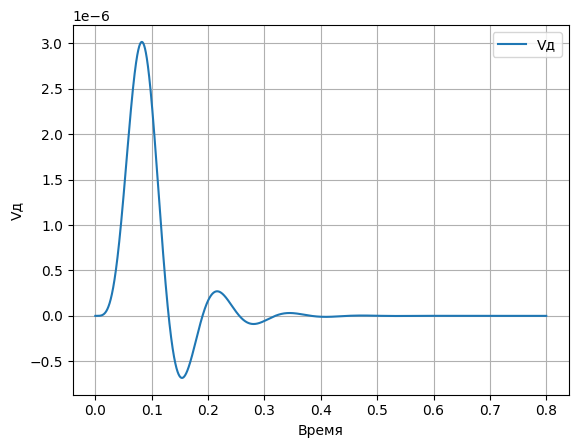

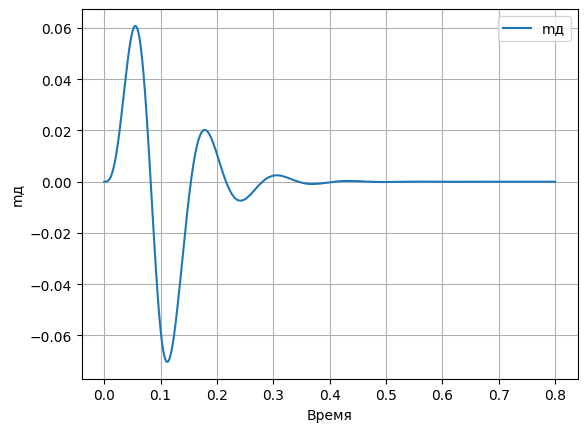

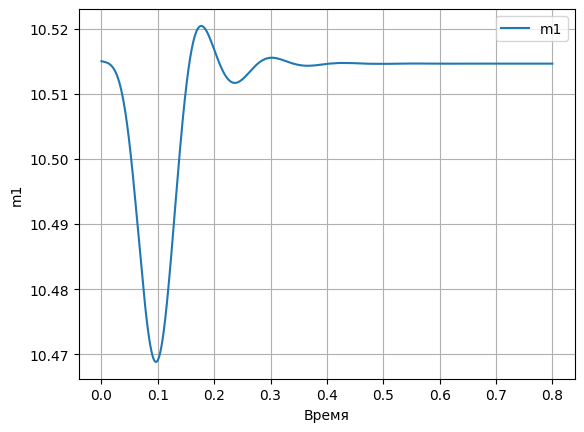

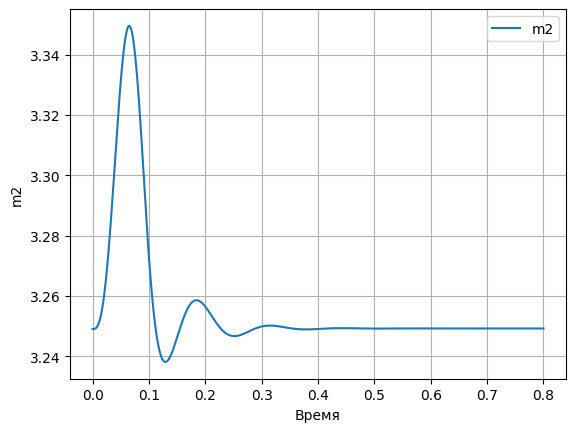

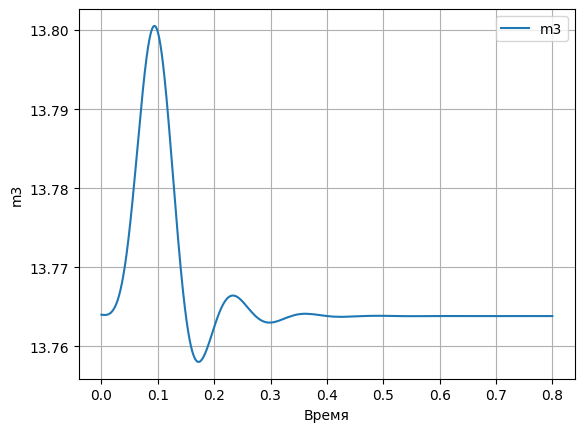

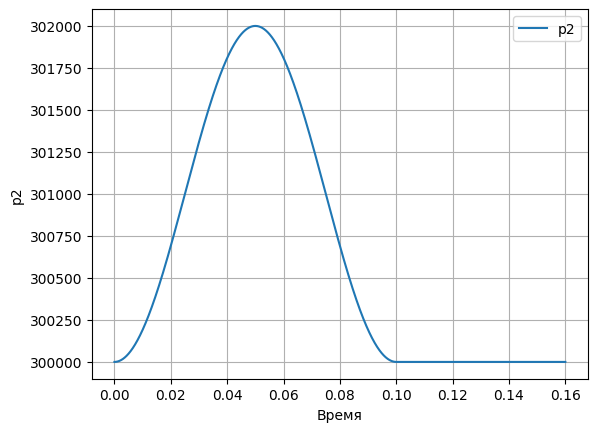

In [6]:
from matplotlib import pyplot as plt

def plot(t, y, label):
    plt.plot(t, y, label=label)
    plt.grid(True)
    plt.xlabel("Время")
    plt.ylabel(label)
    plt.legend()
    plt.show()


# plot(t[-100000:], sol[-100000:, 0], "p4")
plot(t[:], sol[:, 0], r"$p_4$")
plot(t, sol[:, 1], r"$V_д$")
plot(t, sol[:, 2], r"$m_д$")
plot(t, sol[:, 3], r"$m_1$")
plot(t, sol[:, 4], r"$m_2$")
plot(t, sol[:, 5], r"$m_3$")
plot(t[:int(t_end/h/5)], [p2(t) for t in t][:int(t_end/h/5)], "p2")

#### Решение методом `Рунге-Кутта`

## Сравнение методов LSODA и Рунге-Кутта

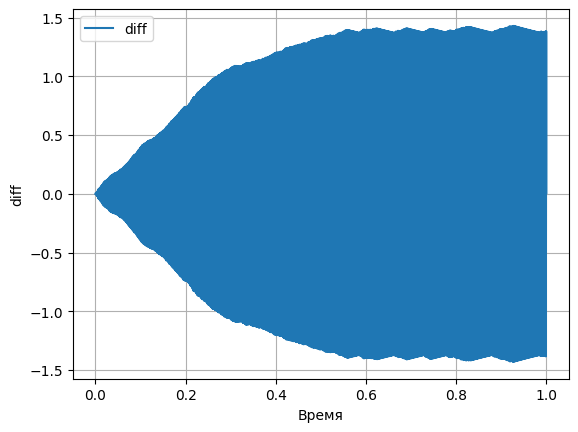

In [46]:
lsoda = sol[:, 0]
rk = sol_rk.y.T[:, 0]
diff = sol[:, 0] - sol_rk.y.T[:1_000_000, 0]
diff
plot(t[:], diff[:], "diff")
